In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import HTML
from datetime import datetime
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"

## GET DATA

In [9]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '331106',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/tQVVSXcmYLvAoI28cp-2Tg__thumb/img/ahKWaUSws5zja4feB4VexkNV3Mc=/fit-in/200x150/filters:strip_icc()/pic5974859.jpg',
  'name': 'The Witcher: Old World',
  'yearpublished': '2022'},
 {'id': '312484',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/6GqH14TJJhza86BX5HCLEQ__thumb/img/J8SVmGOJXZGxNjkT3xYNQU7Haxg=/fit-in/200x150/filters:strip_icc()/pic5674958.jpg',
  'name': 'Lost Ruins of Arnak',
  'yearpublished': '2020'}]

In [10]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 24)
page number = 20 (max: 100, len: 16)
page number = 30 (max: 100, len: 11)
page number = 40 (max: 100, len: 9)
page number = 50 (max: 100, len: 4)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (90326, 4)


,id,username,rating,value
0,331106,aggers,N/A,Kickstarter
1,331106,Allethar,N/A,I played twice during testing phase - the vani...
2,331106,arnaud4matagot,9,tested online
3,331106,arsaghar,3,"The game, apart from really nice figures and g..."
4,331106,Baartoszz,8,Played near final prototype. Great combination...
...,...,...,...,...
90321,167791,z_zadar,9,Some games are so much fun. Others can be a li...
90322,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
90323,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
90324,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [11]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [12]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15151 for 'remove_short_comments' - min len: 25 - method: unrated


In [13]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [14]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10       14249
9        13917
8        11808
7         6630
N/A       6415
         ...  
6.59         1
7.22         1
8.965        1
8.677        1
9.94         1
Name: rating, Length: 510, dtype: int64

In [15]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(68760, 5)

In [16]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6415, 5)

## CREATE TRAINING AND VALIDATION DATA

In [17]:
# use rated comments (reviews) to train the model

In [18]:
rated_comments = rated_comments.sample(frac=1)

In [19]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [20]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"Very nice gameplay with lots of opportunities, heavy as i like ?. Beaaaaautiful and best hardware i've seen in the boardgame i know (not a lot)"

In [21]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Decision making taking over. Less game than management of decisions at the right time and thus not providing the right atmosphere for the story. No mistaking, mechanics work excellent and look is great too; just to less a game of/with spirit for me.'

## COMPOSE MODEL

In [22]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [23]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
34/34 - 4s - loss: 0.5805 - accuracy: 0.7586 - val_loss: 0.5107 - val_accuracy: 0.8376
Epoch 2/100
34/34 - 2s - loss: 0.4626 - accuracy: 0.8435 - val_loss: 0.4321 - val_accuracy: 0.8424
Epoch 3/100
34/34 - 2s - loss: 0.3816 - accuracy: 0.8510 - val_loss: 0.3744 - val_accuracy: 0.8516
Epoch 4/100
34/34 - 2s - loss: 0.3234 - accuracy: 0.8705 - val_loss: 0.3438 - val_accuracy: 0.8651
Epoch 5/100
34/34 - 2s - loss: 0.2839 - accuracy: 0.8873 - val_loss: 0.3296 - val_accuracy: 0.8708
Epoch 6/100
34/34 - 2s - loss: 0.2538 - accuracy: 0.9005 - val_loss: 0.3228 - val_accuracy: 0.8733
Epoch 7/100
34/34 - 2s - loss: 0.2294 - accuracy: 0.9114 - val_loss: 0.3236 - val_accuracy: 0.8732
Epoch 8/100
34/34 - 2s - loss: 0.2086 - accuracy: 0.9201 - val_loss: 0.3297 - val_accuracy: 0.8721
Epoch 9/100
34/34 - 2s - loss: 0.1905 - accuracy: 0.9284 - val_loss: 0.3355 - val_accuracy: 0.8697
Epoch 10/100
34/34 - 2s - loss: 0.1746 - accuracy: 0.9354 - val_loss: 0.3469 - val_accuracy: 0.8653
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E38FCFBF10>,
             param_grid={})

In [24]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [25]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [27]:
epochs = range(1, len(acc) + 1) 

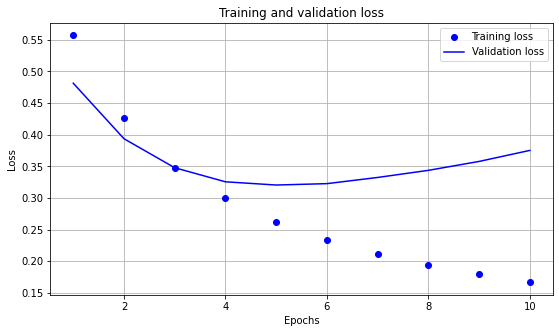

In [28]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

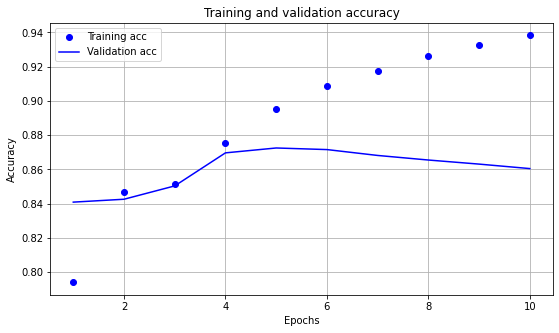

In [29]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [30]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Decision making taking over. Less game than management of decisions at the right time and thus not providing the right atmosphere for the story. No mistaking, mechanics work excellent and look is great too; just to less a game of/with spirit for me."
score: 0.000000
actual value:0

input:
"Very nice gameplay with lots of opportunities, heavy as i like ?. Beaaaaautiful and best hardware i've seen in the boardgame i know (not a lot)"
score: 1.000000
actual value:1

input:
"I want this! It looks so cute"
score: 1.000000
actual value:1

input:
"Superbly balanced game with very clever card play and movement, plays very smoothly and for the number of points earned in a game I am always surprised by how close it can be and how hard it is to see the winner until the end.   The theme itself is not the most engaging and the box size is annoying are my only real gripes."
score: 1.000000
actual value:1

input:
"Gets better after a few games"
score: 1.000000
actual value:1

input:
"with Rai

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
## APPLY MODEL ON NON-RATED COMMENTS

In [32]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

7/7 - 0s
input:
"All-in Kickstarter bundle includes Innkeeper, Oracle and Dragon Rancher expansions"
score: 1.000000

input:
"Go7Gaming Hobby Lobby insert / bit box, coin capsules"
score: 1.000000

input:
"looks cool. Really cool system with voiced APP replayability relizes on new stories which has cool system to create your own or get ones from community.You still would be seeing the same items and people just in different context. Very cool. Will wait for reviews and retail market to see it action for now."
score: 1.000000

input:
"Hasn't been paid for yet, will be paid on 09/06/2021. Shipping costs and possibly VAT will be paid via the pledge manager. Estimated delivery, Q1 2022"
score: 1.000000

input:
"way too complicated for parties. 1 to 4 players."
score: 0.000000

input:
"Sleeved -FFG Grey.  Own: The Riverfolk Expansion The Underworld Expansion Vagabond Pack Exiles and Partisans Deck Resin Clearing Markers "
score: 1.000000

input:
"Andres spoke about Nov. 2019 at Harold Washi

## REGRESSOR

In [33]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001E61B984AF0>,
             param_grid={})

In [34]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [35]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [36]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [37]:
epochs = range(1, len(mean_squared_error) + 1) 

In [38]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.74


In [39]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 0.98


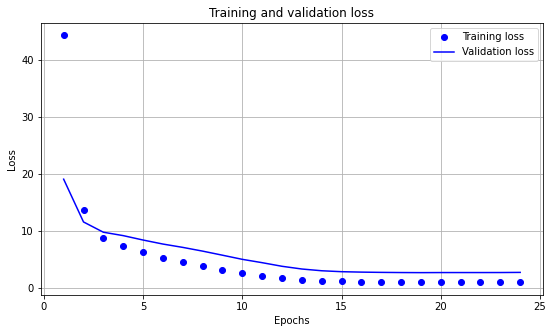

In [40]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

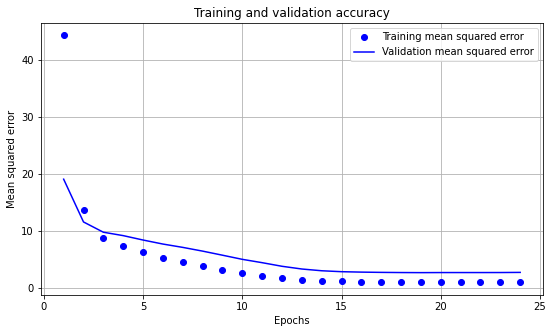

In [41]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [42]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Decision making taking over. Less game than management of decisions at the right time and thus not providing the right atmosphere for the story. No mistaking, mechanics work excellent and look is great too; just to less a game of/with spirit for me."
score: 6.24
actual: 6.00 

input: 
"Very nice gameplay with lots of opportunities, heavy as i like ?. Beaaaaautiful and best hardware i've seen in the boardgame i know (not a lot)"
score: 7.47
actual: 7.50 

input: 
"I want this! It looks so cute"
score: 8.01
actual: 10.00 

input: 
"Superbly balanced game with very clever card play and movement, plays very smoothly and for the number of points earned in a game I am always surprised by how close it can be and how hard it is to see the winner until the end.   The theme itself is not the most engaging and the box size is annoying are my only real gripes."
score: 9.11
actual: 9.00 

input: 
"Gets better after a few games"
score: 8.57
actual: 8.00 

input: 
"with Rails to the North"
s

## COMPARE CLASSIFIER VS REGRESSOR

In [43]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"In the Netherlands. Backed the Kickstarter for this and Brass: Lancashire."
    reg score: 9.53
    clf score: 1

"Consegna stimata MAY 2020 + 3 month for translation"
    reg score: 7.82
    clf score: 1

"2-4 player (2), Co-op ~90-120 mins ~18-19k HUF + expansions Complexity: 3.95"
    reg score: 9.24
    clf score: 1

"incl. Monsters of Avalon and The Fall of Avalon Surprise Box (KS)"
    reg score: 4.33
    clf score: 1

"2-4P (best 3/4) - 90mn  Deluxe edition  Deckbuilding/worker placement  EN"
    reg score: 8.62
    clf score: 1

"Kickstarted: Underworld Warrior Root: The Underworld Expansion Root: The Exiles and Partisans Deck Root: The Vagabond Pack Root: Resin Clearing Markers Root: The Marauder Expansion Riverfolk Hireling Pack Landmarks Pack Six More Hirelings "
    reg score: 9.43
    clf score: 1

"To be played in ~4 people to really enjoy it."
    reg score: 6.72
    clf score: 0

"Sold in October 2020 via ebay  Backed the Kickstarter - All-In!  Arrived Dec 2019"
    re

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [44]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.19 |           3847 |
| 128671 |          7.57 |           1073 |
| 162886 |          8.36 |           3525 |
| 167355 |          8.42 |           1814 |
| 167791 |          8.21 |           8256 |


In [45]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [46]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.04 |            256 |
| 128671 |          7.59 |             98 |
| 162886 |          8.14 |            314 |
| 167355 |          8.21 |            215 |
| 167791 |          8.23 |            439 |


In [47]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [48]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/tQVVSXc...","<a href=""https://boardgamegeek.com/boardgame/3...",6.152174,8.698783,7.397183,1,2022
1,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.842569,7.713243,7.831523,2,2020
2,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.337391,7.055841,8.019098,3,2021
3,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.849466,7.896762,7.866241,4,2021
4,"<img src=""https://cf.geekdo-images.com/z4QtTBa...","<a href=""https://boardgamegeek.com/boardgame/3...",9.100000,9.074135,9.092610,5,2021


In [49]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [50]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Witcher: Old World,6.152174,8.698783,7.397183,1,2022
2,,Lost Ruins of Arnak,7.842569,7.713243,7.831523,2,2020
3,,Destinies,8.337391,7.055841,8.019098,3,2021
4,,Oath: Chronicles of Empire and Exile,7.849466,7.896762,7.866241,4,2021
5,,Lost Ruins of Arnak: The Search for Professor Kutil,9.100000,9.074135,9.092610,5,2021


In [51]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Goonies: Never Say Die,10.000000,4.397733,7.198867,6,2021
2,,Lost Ruins of Arnak: The Search for Professor Kutil,9.100000,9.074135,9.092610,5,2021
3,,Brass: Birmingham,8.682774,8.182205,8.637447,28,2018
4,,Middara: Unintentional Malum – Act 1,8.636377,8.078221,8.504280,26,2019
5,,Gloomhaven: Jaws of the Lion,8.598396,8.080515,8.547026,22,2020


In [52]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Lost Ruins of Arnak: The Search for Professor Kutil,9.100000,9.074135,9.092610,5,2021
2,,Brass: Birmingham,8.682774,8.182205,8.637447,28,2018
3,,Gloomhaven: Jaws of the Lion,8.598396,8.080515,8.547026,22,2020
4,,Middara: Unintentional Malum – Act 1,8.636377,8.078221,8.504280,26,2019
5,,Gloomhaven,8.530407,8.068544,8.492453,16,2017


In [53]:
# model.save('saved_model\my_model')

In [54]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [55]:
# some examples on "long" comments vs short comments

In [56]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [57]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"KS edition contains American style casino chips which don't even have the £ symbol on them - such a shame, sends the theme plummeting."
score: 4.32

"Tried playing it once. The rules were a slog to get through... don’t think I finished the first chapter."
score: 4.87

"I’m not a fan of engine building games because of how slow they start and it’s usually difficult to figure out how to make the right engine to accomplish the most lucrative goals. Everdell was no different for me."
score: 4.94

"Good mechanics, but the rules are Not so good, some cards are Hard to understand and removing the tokens from the Inlay boards was Not so easy. And the worst think is, that u cannot close the Box complete....so the Game is ok but the rest could be better."
score: 4.99

"After a quick game overview, this is only a collect cards to make sets and try to optimize your score. I don't say the game is bad as I did not play the game. But it's just too dry and simple for me."
score: 5.91

"Sounds interes